# Arrest data v2

Date: January 17, 2024

In [190]:
# jupyter nbconvert arrest.ipynb --to html --no-input --output=arrest-data-preview-v2.html
# inv deploy-html-notebooks --dir-name 2024-01-arrest-data

import os

from sqlalchemy import create_engine

from dash import Dash, html, dcc
import plotly.express as px
import pandas as pd

import plotly
plotly.offline.init_notebook_mode()

pg_engine = create_engine("postgresql://copelco@127.0.0.1:5432/traffic_stops_nc")
pg_conn = pg_engine.connect()

In [191]:
def lookup_agencies(agency_names):
    return pd.read_sql(
        f"""
        SELECT
            id
            , name
        FROM nc_agency
        WHERE name ~ '{"|".join(agency_names)}'
        ORDER BY 2
        """,
        pg_conn,
    )
df = lookup_agencies({
    "Durham Police",
    "Raleigh Police",
    "Greensboro Police",
    "Fayetteville Police",
    'Charlotte-Mecklenburg Police',
    
})
agency_ids = df['id'].tolist()
df

id                                     name
0   52  Charlotte-Mecklenburg Police Department
1   80                 Durham Police Department
2   89           Fayetteville Police Department
3  105             Greensboro Police Department
4  225                Raleigh Police Department

In [192]:
from enum import Enum

class StopPurpose(Enum):
    SPEED_LIMIT_VIOLATION         = 1   # Safety Violation
    STOP_LIGHT_SIGN_VIOLATION     = 2   # Safety Violation
    DRIVING_WHILE_IMPAIRED        = 3   # Safety Violation
    SAFE_MOVEMENT_VIOLATION       = 4   # Safety Violation
    VEHICLE_EQUIPMENT_VIOLATION   = 5   # Regulatory and Equipment
    VEHICLE_REGULATORY_VIOLATION  = 6   # Regulatory and Equipment
    OTHER_MOTOR_VEHICLE_VIOLATION = 9   # Regulatory and Equipment
    SEAT_BELT_VIOLATION           = 7   # Regulatory and Equipment
    INVESTIGATION                 = 8   # Investigatory
    CHECKPOINT                    = 10  # Investigatory
    
    @classmethod
    def safety_violation(cls):
        return [cls.SPEED_LIMIT_VIOLATION.value, cls.STOP_LIGHT_SIGN_VIOLATION.value, cls.DRIVING_WHILE_IMPAIRED.value, cls.SAFE_MOVEMENT_VIOLATION.value]
    
    @classmethod
    def regulatory_equipment(cls):
        return [cls.VEHICLE_EQUIPMENT_VIOLATION.value, cls.VEHICLE_REGULATORY_VIOLATION.value, cls.OTHER_MOTOR_VEHICLE_VIOLATION.value, cls.SEAT_BELT_VIOLATION.value]
    
    @classmethod
    def investigatory(cls):
        return [cls.INVESTIGATION.value, cls.CHECKPOINT.value]

In [193]:
colors = (
     px.colors.qualitative.Pastel2[5], # Asian
     px.colors.qualitative.Pastel[9], # Black
     px.colors.qualitative.Antique[2], # Hispanic
     px.colors.qualitative.Set2[2], # Native American
     px.colors.qualitative.Set3[2], # Other
     px.colors.qualitative.Pastel[0], # White
)
color_map = {
    "Asian": px.colors.qualitative.Pastel2[5],
    "Black": px.colors.qualitative.Pastel[9],
    "Hispanic": px.colors.qualitative.Antique[2],
    "Native American": px.colors.qualitative.Set2[2],
    "Other": px.colors.qualitative.Set3[2],
    "White": px.colors.qualitative.Pastel[0],
}
pd.set_option('display.max_rows', 500)

In [194]:
stops_summary_sql = f"""
SELECT
    nc_stop.stop_id
    , date AT TIME ZONE 'America/New_York' AS stop_date
    , EXTRACT(hour FROM date AT TIME ZONE 'America/New_York') AS "hour_of_day"
    , nc_stop.agency_id
    , nc_stop.agency_description AS agency
    , nc_stop.officer_id
    , (CASE WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.safety_violation()))}) THEN 'Safety Violation'
            WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.investigatory()))}) THEN 'Investigatory'
            WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.regulatory_equipment()))}) THEN 'Regulatory and Equipment'
            ELSE 'Other'
       END) as stop_purpose_group
    , (CASE WHEN nc_person.ethnicity = 'H' THEN 'Hispanic'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'A' THEN 'Asian'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'B' THEN 'Black'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'I' THEN 'Native American'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'U' THEN 'Other'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'W' THEN 'White'
       END) as driver_race
    , (CASE WHEN nc_person.gender = 'M' THEN 'male'
            WHEN nc_person.gender = 'F' THEN 'female'
       END) as driver_gender
    , (nc_search.search_id IS NOT NULL) AS driver_searched
    , driver_arrest
FROM "nc_stop"
INNER JOIN "nc_person"
    ON ("nc_stop"."stop_id" = "nc_person"."stop_id" AND "nc_person"."type" = 'D')
LEFT OUTER JOIN "nc_search"
    ON ("nc_stop"."stop_id" = "nc_search"."stop_id")
WHERE nc_stop.agency_id IN ({",".join(map(str, agency_ids))})
"""

# 1. Percentage of stops and searches that led to an arrest for a given race / ethnic group

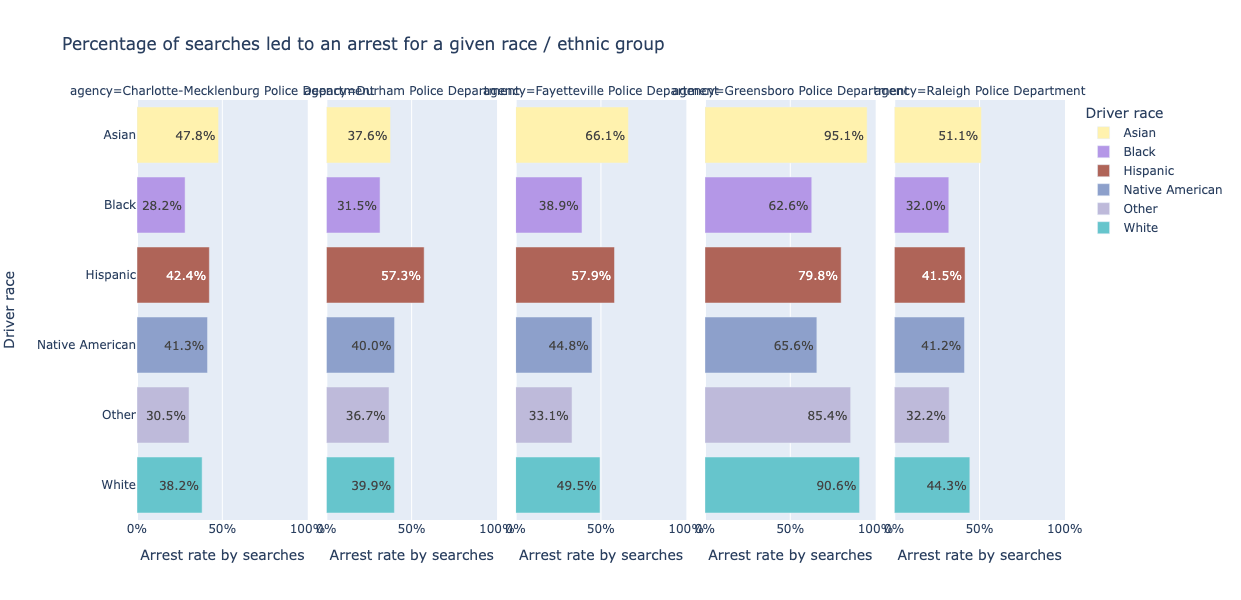

In [195]:
df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        agency
        , driver_race
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
        , count(*) FILTER (WHERE driver_arrest = true) AS arrest_count
    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)
df["search_arrest_rate"] = df.arrest_count / df.search_count
df["stop_arrest_rate"] = df.arrest_count / df.stop_count
fig = px.bar(
    df,
    x="search_arrest_rate",
    y="driver_race",
    color="driver_race",
    color_discrete_map=color_map,
    facet_col="agency",
    title="Percentage of searches led to an arrest for a given race / ethnic group",
    labels={
        "search_arrest_rate": "Arrest rate by searches",
        "driver_race": "Driver race",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    orientation='h',
    height=600,
)
fig.update_xaxes(tickformat=",.0%")
fig

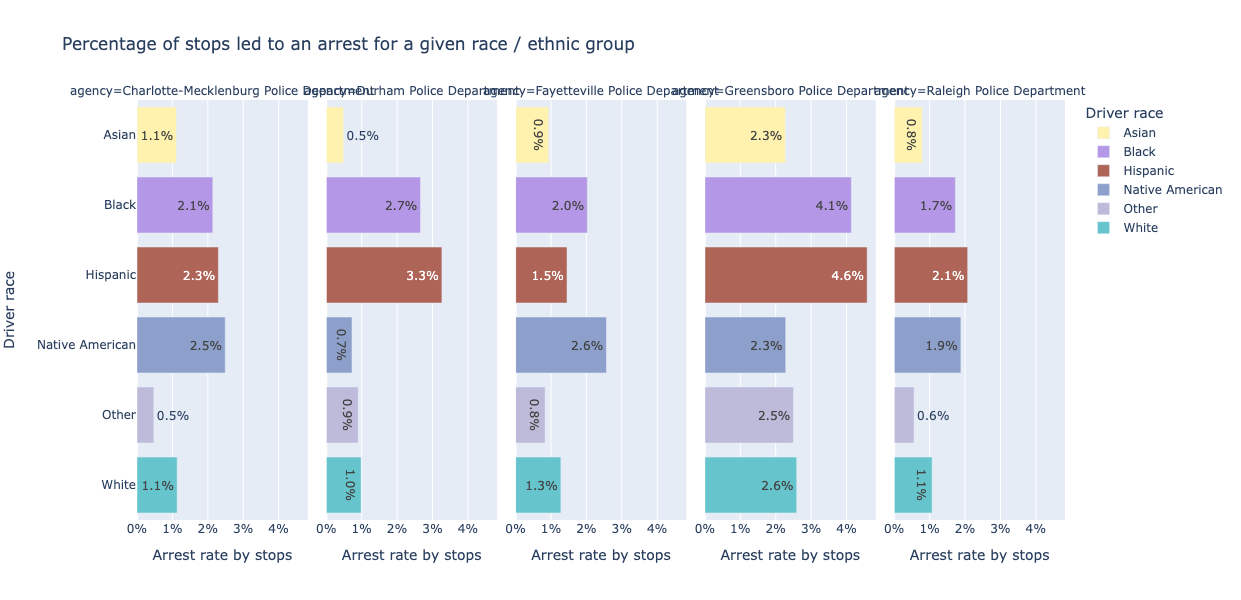

In [196]:
fig = px.bar(
    df,
    x="stop_arrest_rate",
    y="driver_race",
    color="driver_race",
    color_discrete_map=color_map,
    facet_col="agency",
    title="Percentage of stops led to an arrest for a given race / ethnic group",
    labels={
        "stop_arrest_rate": "Arrest rate by stops",
        "driver_race": "Driver race",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    orientation='h',
    height=600,
)
fig.update_xaxes(tickformat=",.0%")
fig

In [197]:
df

agency      driver_race  stop_count  \
0   Charlotte-Mecklenburg Police Department            Asian       37212   
1   Charlotte-Mecklenburg Police Department            Black     1115984   
2   Charlotte-Mecklenburg Police Department         Hispanic      233089   
3   Charlotte-Mecklenburg Police Department  Native American        1244   
4   Charlotte-Mecklenburg Police Department            Other       37142   
5   Charlotte-Mecklenburg Police Department            White      739324   
6                  Durham Police Department            Asian        6584   
7                  Durham Police Department            Black      219420   
8                  Durham Police Department         Hispanic       45796   
9                  Durham Police Department  Native American        1654   
10                 Durham Police Department            Other        2001   
11                 Durham Police Department            White      101977   
12           Fayetteville Police Department            Asian       12493   
13           Fayetteville Police Department            Black      444754   
14           Fayetteville Police Department         Hispanic       49265   
15           Fayetteville Police Department  Native American        7484   
16           Fayetteville Police Department            Other        4799   
17           Fayetteville Police Department            White      267851   
18             Greensboro Police Department            Asian       12705   
19             Greensboro Police Department            Black      369404   
20             Greensboro Police Department         Hispanic       34899   
21             Greensboro Police Department  Native American        2674   
22             Greensboro Police Department            Other        6078   
23             Greensboro Police Department            White      278079   
24                Raleigh Police Department            Asian       20567   
25                Raleigh Police Department            Black      538360   
26                Raleigh Police Department         Hispanic      115714   
27                Raleigh Police Department  Native American         744   
28                Raleigh Police Department            Other       13605   
29                Raleigh Police Department            White      454127   

    search_count  arrest_count  search_arrest_rate  stop_arrest_rate  
0            866           414            0.478060          0.011125  
1          84775         23895            0.281864          0.021412  
2          12634          5358            0.424094          0.022987  
3             75            31            0.413333          0.024920  
4            577           176            0.305026          0.004739  
5          21961          8382            0.381677          0.011337  
6             85            32            0.376471          0.004860  
7          18527          5836            0.315000          0.026597  
8           2607          1495            0.573456          0.032645  
9             30            12            0.400000          0.007255  
10            49            18            0.367347          0.008996  
11          2511          1002            0.399044          0.009826  
12           177           117            0.661017          0.009365  
13         23151          9005            0.388968          0.020247  
14          1234           715            0.579417          0.014513  
15           429           192            0.447552          0.025655  
16           121            40            0.330579          0.008335  
17          6920          3422            0.494509          0.012776  
18           304           289            0.950658          0.022747  
19         24404         15277            0.626004          0.041356  
20          2003          1599            0.798303          0.045818  
21            93            61            0.655914          0.022812  
22           178           152            0.853

# 2. Percentage of stops and searches that led to an arrest for a given stop purpose

In [198]:
df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        agency
        , stop_purpose_group
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
        , count(*) FILTER (WHERE driver_arrest = true) AS arrest_count
    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)
df["search_arrest_rate"] = df.arrest_count / df.search_count
df["stop_arrest_rate"] = df.arrest_count / df.stop_count

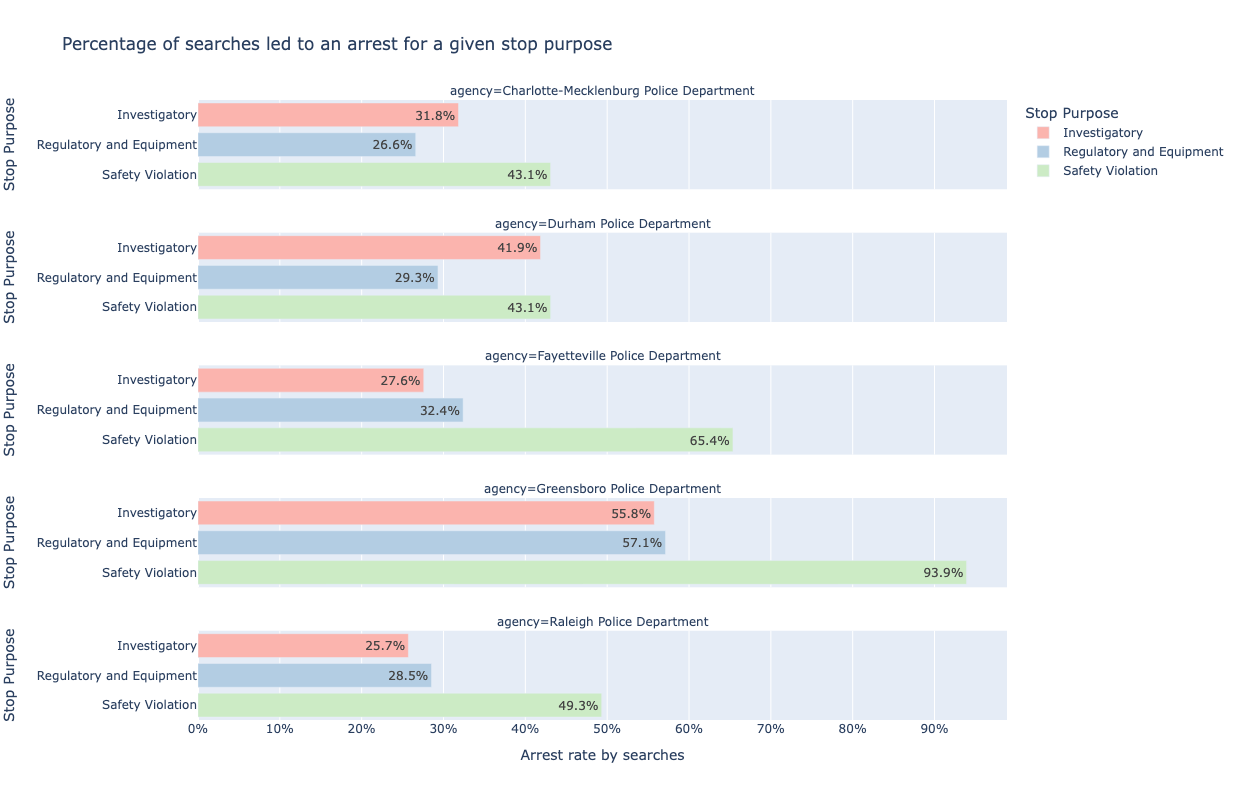

In [199]:
fig = px.bar(
    df,
    x="search_arrest_rate",
    y="stop_purpose_group",
    color="stop_purpose_group",
    color_discrete_sequence=px.colors.qualitative.Pastel1,
    facet_col="agency",
    facet_col_wrap=1,
    title="Percentage of searches led to an arrest for a given stop purpose",
    labels={
        "search_arrest_rate": "Arrest rate by searches",
        "driver_race": "Driver race",
        "stop_purpose_group": "Stop Purpose",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    orientation='h',
    height=800,
)
fig.update_xaxes(tickformat=",.0%")
# fig.update_yaxes(visible=False)
fig

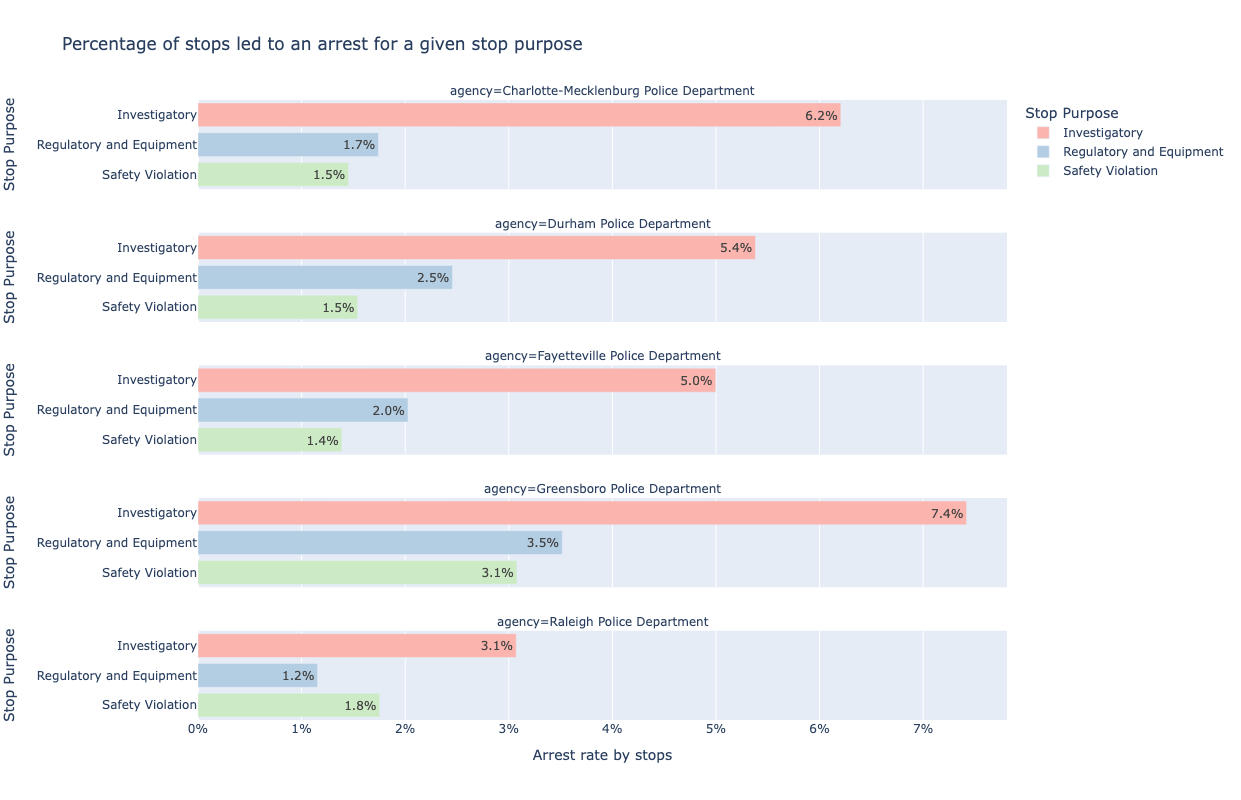

In [200]:
fig = px.bar(
    df,
    x="stop_arrest_rate",
    y="stop_purpose_group",
    color="stop_purpose_group",
    color_discrete_sequence=px.colors.qualitative.Pastel1,
    facet_col="agency",
    facet_col_wrap=1,
    title="Percentage of stops led to an arrest for a given stop purpose",
    labels={
        "stop_arrest_rate": "Arrest rate by stops",
        "driver_race": "Driver race",
        "stop_purpose_group": "Stop Purpose",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    orientation='h',
    height=800,
)
fig.update_xaxes(tickformat=",.0%")
fig

In [201]:
df

agency        stop_purpose_group  \
0   Charlotte-Mecklenburg Police Department             Investigatory   
1   Charlotte-Mecklenburg Police Department  Regulatory and Equipment   
2   Charlotte-Mecklenburg Police Department          Safety Violation   
3                  Durham Police Department             Investigatory   
4                  Durham Police Department  Regulatory and Equipment   
5                  Durham Police Department          Safety Violation   
6            Fayetteville Police Department             Investigatory   
7            Fayetteville Police Department  Regulatory and Equipment   
8            Fayetteville Police Department          Safety Violation   
9              Greensboro Police Department             Investigatory   
10             Greensboro Police Department  Regulatory and Equipment   
11             Greensboro Police Department          Safety Violation   
12                Raleigh Police Department             Investigatory   
13                Raleigh Police Department  Regulatory and Equipment   
14                Raleigh Police Department          Safety Violation   

    stop_count  search_count  arrest_count  search_arrest_rate  \
0        74741         14571          4638            0.318303   
1      1129335         73947         19672            0.266028   
2       959919         32370         13946            0.430831   
3        29507          3794          1588            0.418556   
4       157547         13201          3871            0.293235   
5       190378          6814          2936            0.430878   
6        17289          3132           864            0.275862   
7       303613         18999          6155            0.323964   
8       465744          9901          6472            0.653671   
9        39480          5253          2929            0.557586   
10      274631         16904          9657            0.571285   
11      389728         12778         12000            0.939114   
12       32852          3925          1009            0.257070   
13      613486         24812          7079            0.285305   
14      496779         17664          8713            0.493263   

    stop_arrest_rate  
0           0.062054  
1           0.017419  
2           0.014528  
3           0.053818  
4           0.024570  
5           0.015422  
6           0.049974  
7           0.020273  
8           0.013896  
9           0.074189  
10          0.035164  
11          0.030791  
12          0.030714  
13          0.011539  
14          0.017539

# 3. Percentage of stops and searches that led to an arrest for a given stop purpose and race / ethnic group

In [202]:
df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        agency
        , driver_race
        , stop_purpose_group
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
        , count(*) FILTER (WHERE driver_arrest = true) AS arrest_count
    FROM stops
    GROUP BY 1, 2, 3
    """,
    pg_engine,
)
df["search_arrest_rate"] = df.arrest_count / df.search_count
df["stop_arrest_rate"] = df.arrest_count / df.stop_count

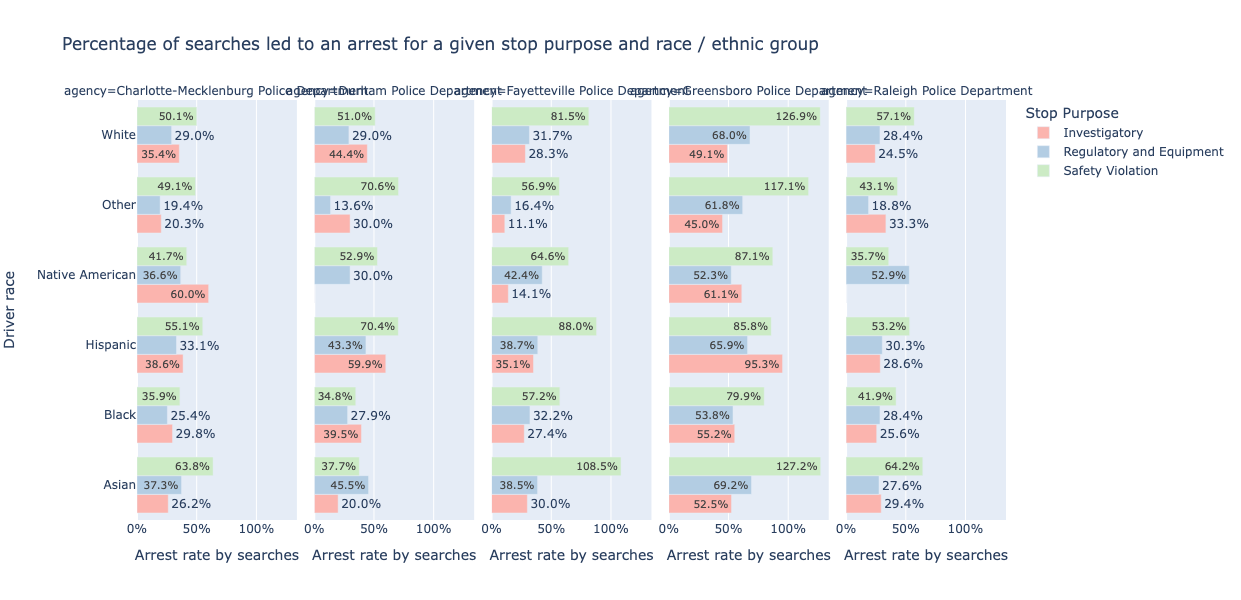

In [203]:
fig = px.bar(
    df,
    x="search_arrest_rate",
    y="driver_race",
    color="stop_purpose_group",
    color_discrete_sequence=px.colors.qualitative.Pastel1,
    facet_col="agency",
    title="Percentage of searches led to an arrest for a given stop purpose and race / ethnic group",
    labels={
        "search_arrest_rate": "Arrest rate by searches",
        "driver_race": "Driver race",
        "stop_purpose_group": "Stop Purpose",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    barmode="group",
    orientation='h',
    height=600,
)
fig.update_xaxes(tickformat=",.0%")
fig

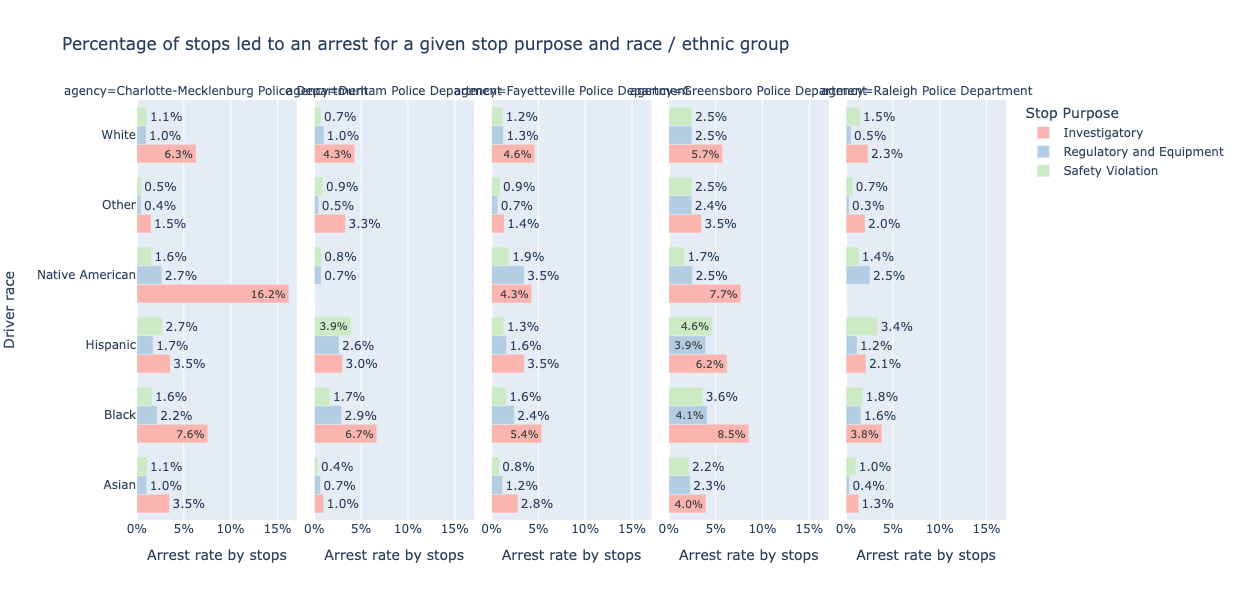

In [204]:
fig = px.bar(
    df,
    x="stop_arrest_rate",
    y="driver_race",
    color="stop_purpose_group",
    color_discrete_sequence=px.colors.qualitative.Pastel1,
    facet_col="agency",
    title="Percentage of stops led to an arrest for a given stop purpose and race / ethnic group",
    labels={
        "search_arrest_rate": "Arrest rate by searches",
        "driver_race": "Driver race",
        "stop_purpose_group": "Stop Purpose",
        "stop_arrest_rate": "Arrest rate by stops",
    },
    text='search_arrest_rate',
    text_auto=',.1%',
    barmode="group",
    orientation='h',
    height=600,
)
fig.update_xaxes(tickformat=",.0%")
fig

In [205]:
df

agency      driver_race  \
0   Charlotte-Mecklenburg Police Department            Asian   
1   Charlotte-Mecklenburg Police Department            Asian   
2   Charlotte-Mecklenburg Police Department            Asian   
3   Charlotte-Mecklenburg Police Department            Black   
4   Charlotte-Mecklenburg Police Department            Black   
5   Charlotte-Mecklenburg Police Department            Black   
6   Charlotte-Mecklenburg Police Department         Hispanic   
7   Charlotte-Mecklenburg Police Department         Hispanic   
8   Charlotte-Mecklenburg Police Department         Hispanic   
9   Charlotte-Mecklenburg Police Department  Native American   
10  Charlotte-Mecklenburg Police Department  Native American   
11  Charlotte-Mecklenburg Police Department  Native American   
12  Charlotte-Mecklenburg Police Department            Other   
13  Charlotte-Mecklenburg Police Department            Other   
14  Charlotte-Mecklenburg Police Department            Other   
15  Charlotte-Mecklenburg Police Department            White   
16  Charlotte-Mecklenburg Police Department            White   
17  Charlotte-Mecklenburg Police Department            White   
18                 Durham Police Department            Asian   
19                 Durham Police Department            Asian   
20                 Durham Police Department            Asian   
21                 Durham Police Department            Black   
22                 Durham Police Department            Black   
23                 Durham Police Department            Black   
24                 Durham Police Department         Hispanic   
25                 Durham Police Department         Hispanic   
26                 Durham Police Department         Hispanic   
27                 Durham Police Department  Native American   
28                 Durham Police Department  Native American   
29                 Durham Police Department  Native American   
30                 Durham Police Department            Other   
31                 Durham Police Department            Other   
32                 Durham Police Department            Other   
33                 Durham Police Department            White   
34                 Durham Police Department            White   
35                 Durham Police Department            White   
36           Fayetteville Police Department            Asian   
37           Fayetteville Police Department            Asian   
38           Fayetteville Police Department            Asian   
39           Fayetteville Police Department            Black   
40           Fayetteville Police Department            Black   
41           Fayetteville Police Department            Black   
42           Fayetteville Police Department         Hispanic   
43           Fayetteville Police Department         Hispanic   
44           Fayetteville Police Department         Hispanic   
45           Fayetteville Police Department  Native American   
46           Fayetteville Police Department  Native American   
47           Fayetteville Police Department  Native American   
48           Fayetteville Police Department            Other   
49           Fayetteville Police Department            Other   
50           Fayetteville Police Department            Other   
51           Fayetteville Police Department            White   
52           Fayetteville Police Department            White   
53           Fayetteville Police Department            White   
54             Greensboro Police Department            Asian   
55             Greensboro Police Department            Asian   
56             Greensboro Police Department            Asian   
57             Greensboro Police Department            Black   
58             Greensboro Police Department            Black   
59             Greensboro Police Department            Black   
60             Greensboro Police Department         Hispanic   
61             Greensboro Police Department         Hispanic   
62   

# 4. Count of stops and arrests for a given race / ethnic group

In [206]:
df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        agency
        , driver_race
        , count(*) AS Stops
        , count(*) FILTER (WHERE driver_arrest = true) AS Arrests
    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)

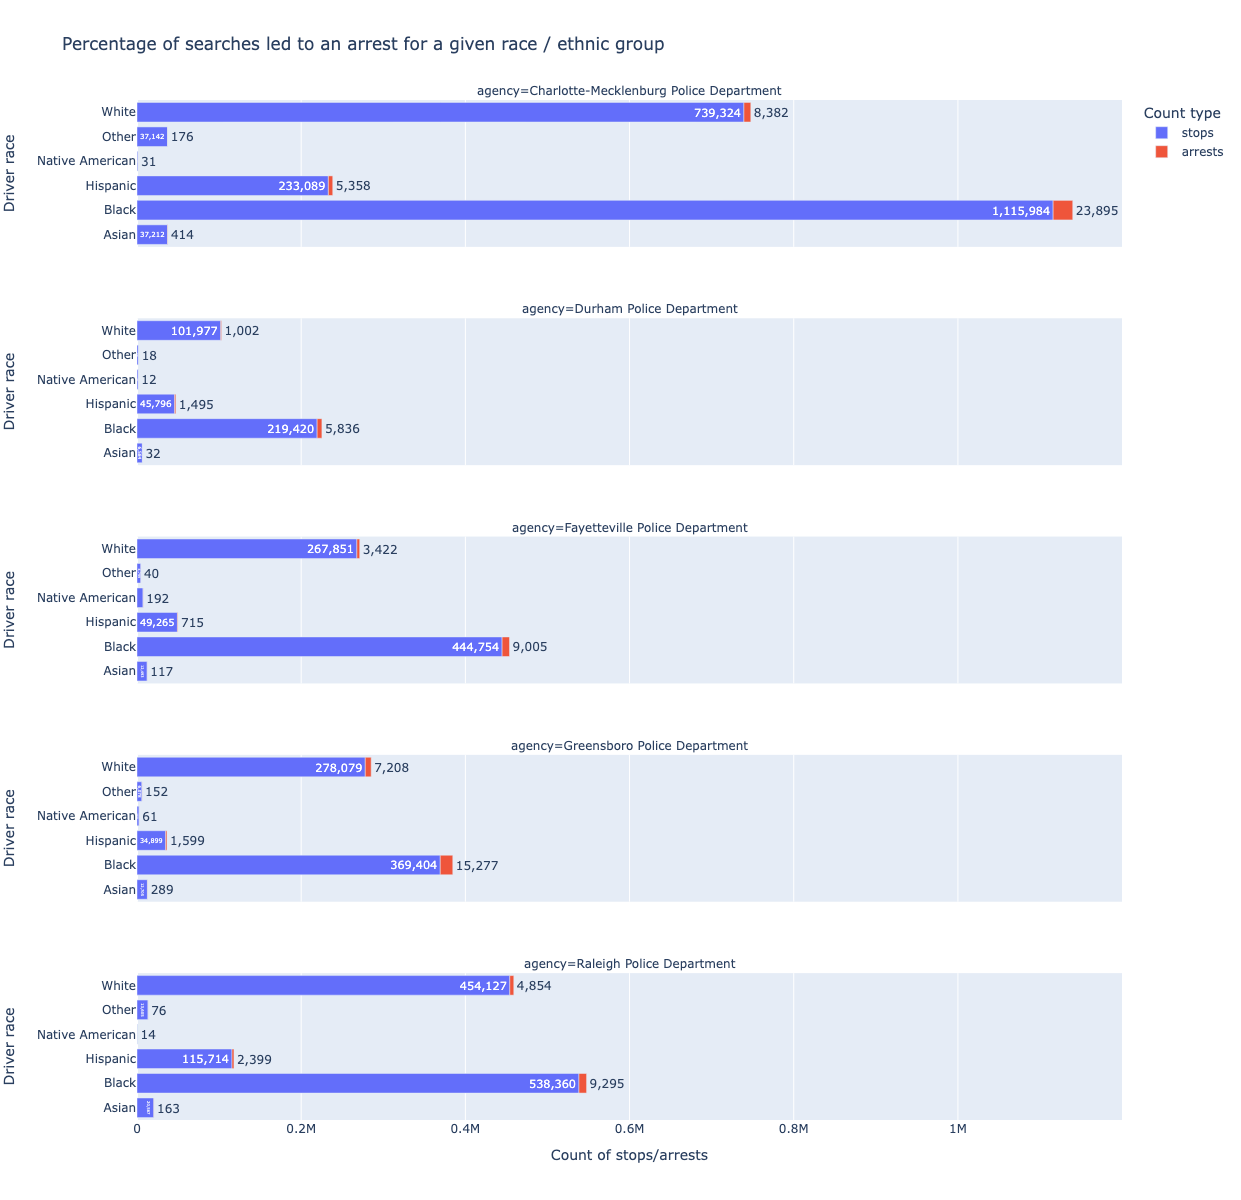

In [207]:
fig = px.bar(
    df.melt(id_vars=["agency", "driver_race"], value_vars=["stops", "arrests"], var_name="count_type", value_name="count"),
    x="count",
    y="driver_race",
    color="count_type",
    # color_discrete_map=color_map,
    facet_col="agency",
    facet_col_wrap=1,
    title="Percentage of searches led to an arrest for a given race / ethnic group",
    labels={
        "search_arrest_rate": "Arrest rate by searches",
        "driver_race": "Driver race",
        "count": "Count of stops/arrests",
        "count_type": "Count type",
    },
    text='count',
    text_auto=',',
    orientation='h',
    height=1200,
)
fig

In [208]:
df

agency      driver_race    stops  arrests
0   Charlotte-Mecklenburg Police Department            Asian    37212      414
1   Charlotte-Mecklenburg Police Department            Black  1115984    23895
2   Charlotte-Mecklenburg Police Department         Hispanic   233089     5358
3   Charlotte-Mecklenburg Police Department  Native American     1244       31
4   Charlotte-Mecklenburg Police Department            Other    37142      176
5   Charlotte-Mecklenburg Police Department            White   739324     8382
6                  Durham Police Department            Asian     6584       32
7                  Durham Police Department            Black   219420     5836
8                  Durham Police Department         Hispanic    45796     1495
9                  Durham Police Department  Native American     1654       12
10                 Durham Police Department            Other     2001       18
11                 Durham Police Department            White   101977     1002
12           Fayetteville Police Department            Asian    12493      117
13           Fayetteville Police Department            Black   444754     9005
14           Fayetteville Police Department         Hispanic    49265      715
15           Fayetteville Police Department  Native American     7484      192
16           Fayetteville Police Department            Other     4799       40
17           Fayetteville Police Department            White   267851     3422
18             Greensboro Police Department            Asian    12705      289
19             Greensboro Police Department            Black   369404    15277
20             Greensboro Police Department         Hispanic    34899     1599
21             Greensboro Police Department  Native American     2674       61
22             Greensboro Police Department            Other     6078      152
23             Greensboro Police Department            White   278079     7208
24                Raleigh Police Department            Asian    20567      163
25                Raleigh Police Department            Black   538360     9295
26                Raleigh Police Department         Hispanic   115714     2399
27                Raleigh Police Department  Native American      744       14
28                Raleigh Police Department            Other    13605       76
29                Raleigh Police Department            White   454127     4854